In [ ]:
!pip install tensorflow
!pip install tensorflow.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 163.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 183.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.2 MB/s eta 0:00:00


In [ ]:
# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers



/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# cargamos datos
df = pd.read_csv("datos_integrados.csv", parse_dates=["datetime"])


In [ ]:
# ========= 2) Separar por estación
estaciones = df["nombre"].unique()
df_por_estacion = {est: df[df["nombre"] == est].sort_values("datetime").copy() for est in estaciones}

In [ ]:
print(df_por_estacion.keys())

dict_keys(['ALGECIRAS EPS', 'JEREZ-CHAPMN', 'SAN FERNANDO'])


In [ ]:
# ============================
# LSTM vanilla + Permutation Importance por estación
# ============================

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def make_sequences(X2d, y1d, lookback=72, horizon=1):
    T = len(X2d)
    N = T - lookback - horizon + 1
    if N <= 0:
        raise ValueError(f"No hay suficientes datos para lookback={lookback} y horizon={horizon} (T={T}).")
    Xs = np.empty((N, lookback, X2d.shape[1]), dtype=X2d.dtype)
    ys = np.empty((N,), dtype=y1d.dtype)
    for i in range(N):
        Xs[i] = X2d[i:i+lookback, :]
        ys[i] = y1d[i + lookback + horizon - 1]
    return Xs, ys

def build_lstm_vanilla(n_features, lookback, lr=1e-3, units=64, drop=0.2):
    model = models.Sequential([
        layers.Input(shape=(lookback, n_features)),
        layers.LSTM(units),
        layers.Dropout(drop),
        layers.Dense(1)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mae")
    return model

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# ---------------------------
# Permutation Importance
# ---------------------------
def permutation_importance_lstm(model,
                                X_te_2d_s, y_te_1d_s,
                                scaler_y, feature_names,
                                lookback=72, horizon=1,
                                metric="mae", n_repeats=1,
                                random_state=SEED):
    rng = np.random.RandomState(random_state)

    # baseline
    X_base_3d, y_base_s = make_sequences(X_te_2d_s, y_te_1d_s, lookback, horizon)
    y_pred_base_s = model.predict(X_base_3d, verbose=0).ravel()
    y_pred_base = scaler_y.inverse_transform(y_pred_base_s.reshape(-1,1)).ravel()
    y_true = scaler_y.inverse_transform(y_base_s.reshape(-1,1)).ravel()

    if metric.lower() == "mae":
        base = mean_absolute_error(y_true, y_pred_base)
        scorer = lambda yt, yp: mean_absolute_error(yt, yp)
        label = "MAE"
    else:
        base = rmse(y_true, y_pred_base)
        scorer = lambda yt, yp: rmse(yt, yp)
        label = "RMSE"

    importances = []
    for j in range(X_te_2d_s.shape[1]):
        worse = []
        for _ in range(n_repeats):
            X_perm = X_te_2d_s.copy()
            rng.shuffle(X_perm[:, j])
            Xp_3d, yp_s = make_sequences(X_perm, y_te_1d_s, lookback, horizon)
            y_pred_p_s = model.predict(Xp_3d, verbose=0).ravel()
            y_pred_p = scaler_y.inverse_transform(y_pred_p_s.reshape(-1,1)).ravel()
            y_true_p = scaler_y.inverse_transform(yp_s.reshape(-1,1)).ravel()
            worse.append(scorer(y_true_p, y_pred_p))
        imp = np.mean(worse) - base
        importances.append(imp)

    return pd.DataFrame({
        "feature": feature_names,
        f"delta_{label}": importances
    }).sort_values(by=f"delta_{label}", ascending=False).reset_index(drop=True), label

# ---------------------------
# Entrenamiento + gráficos
# ---------------------------
def train_lstm_station_vanilla(df_estacion: pd.DataFrame,
                               lookback=72, horizon=1,
                               epochs=60, batch_size=256,
                               lr=1e-3, units=64, drop=0.2,
                               plot_color="#1f77b4",
                               save_csv=False, nombre_estacion="ESTACION"):
    d = df_estacion.sort_values("datetime").reset_index(drop=True).copy()

    vars_keep = ["o3", "no2","temperature_2m", "wind_speed_10m","relative_humidity_2m"]
    cols = [c for c in vars_keep if c in d.columns]

    X_all = d[cols].astype(np.float32).values
    y_all = d["o3"].astype(np.float32).values

    n = len(d)
    i_train, i_valid = int(n*0.7), int(n*0.8)

    X_tr, X_va, X_te = X_all[:i_train], X_all[i_train:i_valid], X_all[i_valid:]
    y_tr, y_va, y_te = y_all[:i_train], y_all[i_train:i_valid], y_all[i_valid:]
    fechas_test = d["datetime"].iloc[i_valid:]

    sx, sy = MinMaxScaler(), MinMaxScaler()
    X_tr_s, X_va_s, X_te_s = sx.fit_transform(X_tr), sx.transform(X_va), sx.transform(X_te)
    y_tr_s = sy.fit_transform(y_tr.reshape(-1,1)).ravel()
    y_va_s = sy.transform(y_va.reshape(-1,1)).ravel()
    y_te_s = sy.transform(y_te.reshape(-1,1)).ravel()

    X_tr_3d, y_tr_seq = make_sequences(X_tr_s, y_tr_s, lookback, horizon)
    X_va_3d, y_va_seq = make_sequences(X_va_s, y_va_s, lookback, horizon)
    X_te_3d, y_te_seq = make_sequences(X_te_s, y_te_s, lookback, horizon)

    offset = lookback + horizon - 1
    fechas_test_alineadas = fechas_test.iloc[offset:]

    model = build_lstm_vanilla(X_tr_3d.shape[2], lookback, lr=lr, units=units, drop=drop)
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)

    model.fit(X_tr_3d, y_tr_seq, validation_data=(X_va_3d, y_va_seq),
              epochs=epochs, batch_size=batch_size, callbacks=[es, rlr], verbose=1)

    y_pred_s = model.predict(X_te_3d, verbose=0).ravel()
    y_pred = sy.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
    y_true = sy.inverse_transform(y_te_seq.reshape(-1,1)).ravel()

    mae_, rmse_ = mean_absolute_error(y_true, y_pred), rmse(y_true, y_pred)
    print(f"[{nombre_estacion}] TEST -> RMSE={rmse_:.2f}  MAE={mae_:.2f}")

    # --- gráfico Real vs Predicción
    plt.figure(figsize=(14,5))
    plt.plot(fechas_test_alineadas, y_true, label="Real", color="black", lw=0.7)
    plt.plot(fechas_test_alineadas, y_pred, label="Predicción LSTM", color=plot_color, lw=1.0)
    plt.title(f"O₃ - {nombre_estacion} (Real vs Predicción) - LSTM vanilla")
    plt.xlabel("Fecha"); plt.ylabel("O₃ (µg/m³)")
    plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

    # --- Permutation Importance
    imp_df, label = permutation_importance_lstm(model, X_te_s, y_te_s, sy, cols,
                                                lookback=lookback, horizon=horizon, metric="mae")
    top = imp_df.head(12).iloc[::-1]
    plt.figure(figsize=(9,5))
    plt.barh(top["feature"], top[f"delta_{label}"], color=plot_color, alpha=0.8)
    for i, v in enumerate(top[f"delta_{label}"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
    plt.xlabel(f"Aumento de {label} al permutar")
    plt.title(f"Permutation Importance - {nombre_estacion}")
    plt.grid(axis='x', linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

    return {
        "metrics": {"RMSE": rmse_, "MAE": mae_},
        "model": model,
        "importances": imp_df
    }

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1130 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0632 - val_loss: 0.0688 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0554 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0503 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0479 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0460 - val_loss: 0.0554 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0449 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0435 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0431 - val_loss: 0.0537 - learning_rate: 0.0010
E

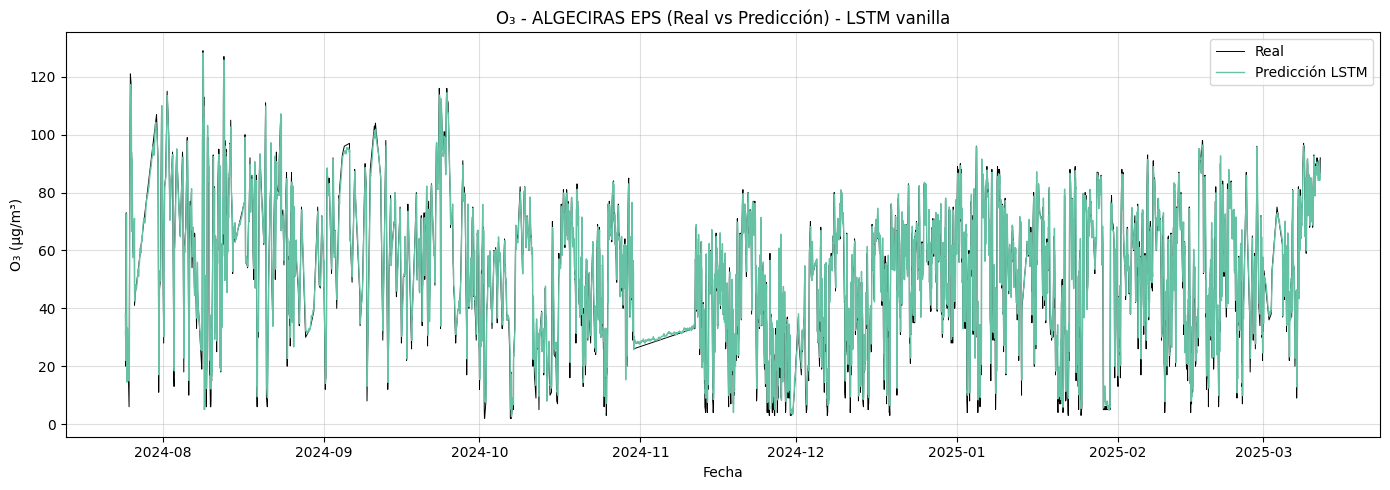

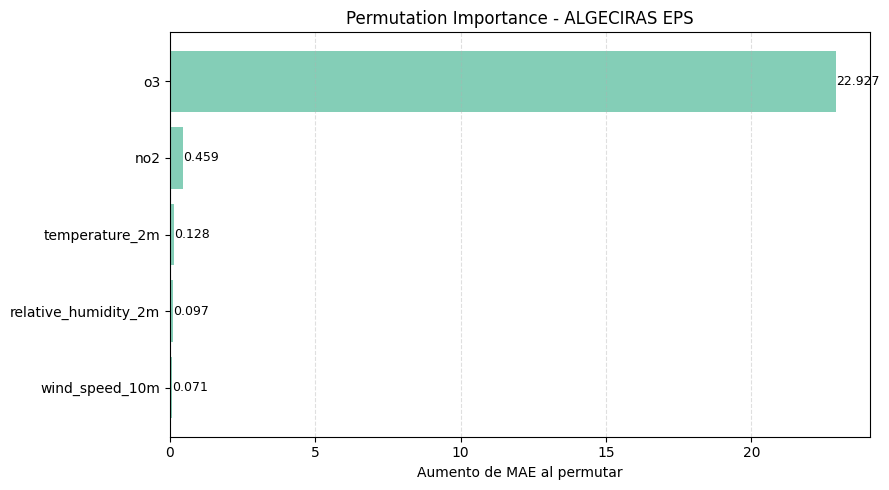

In [ ]:
salida = train_lstm_station_vanilla(
    df_por_estacion["ALGECIRAS EPS"],
    lookback=72, horizon=1,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#66c2a5",
    nombre_estacion="ALGECIRAS EPS"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1086 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0535 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0447 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0394 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0360 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0336 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0321 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0302 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0294 - val_loss: 0.0280 - learning_rate: 0.0010
E

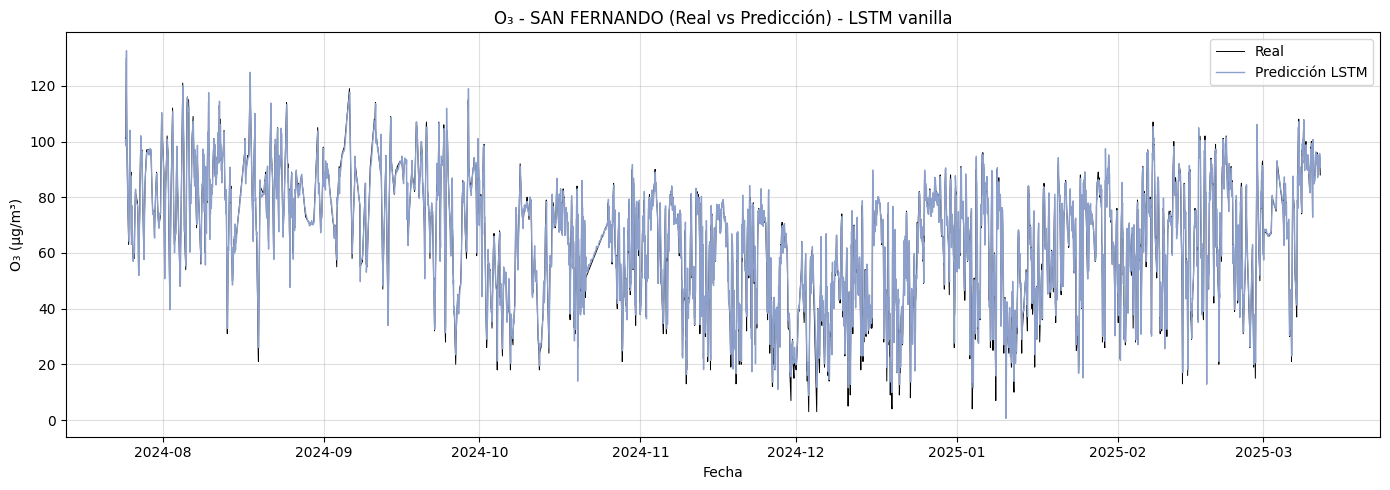

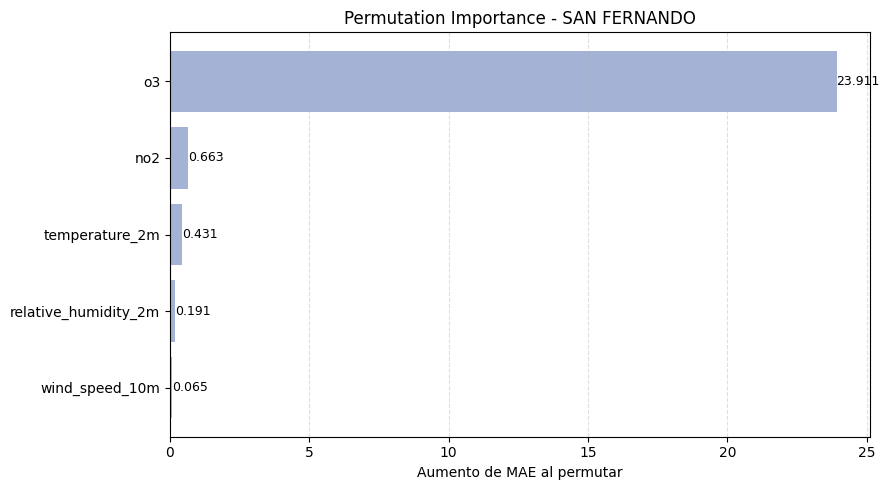

In [ ]:
salida = train_lstm_station_vanilla(
    df_por_estacion["SAN FERNANDO"],
    lookback=72, horizon=1,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#8da0cb",
    nombre_estacion="SAN FERNANDO"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0940 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0525 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0441 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0388 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0359 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0341 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0322 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0309 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0297 - val_loss: 0.0280 - learning_rate: 0.0010
E

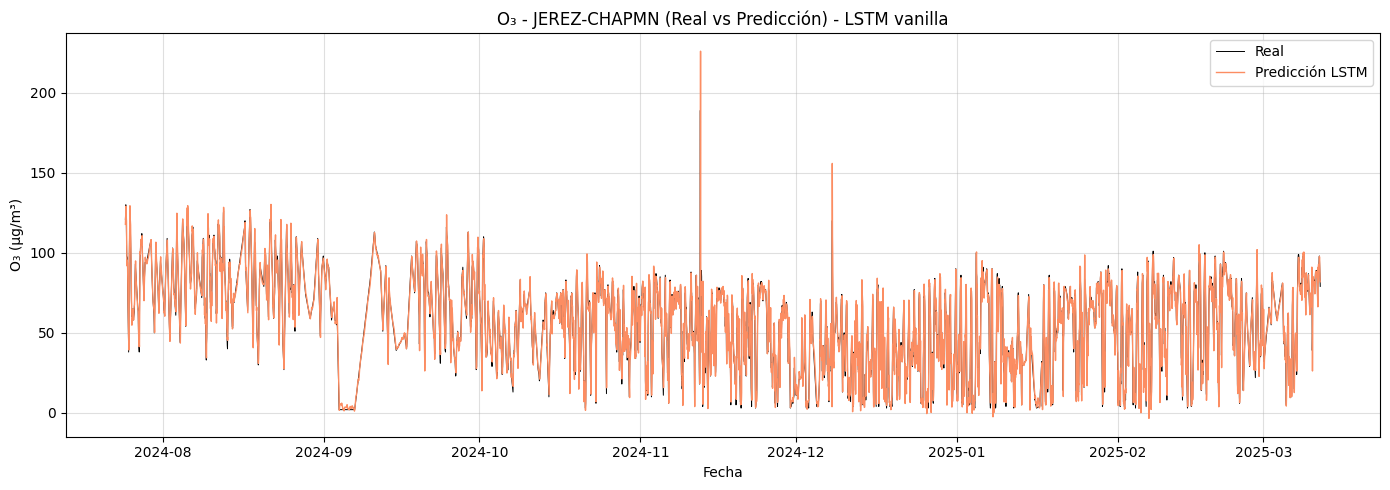

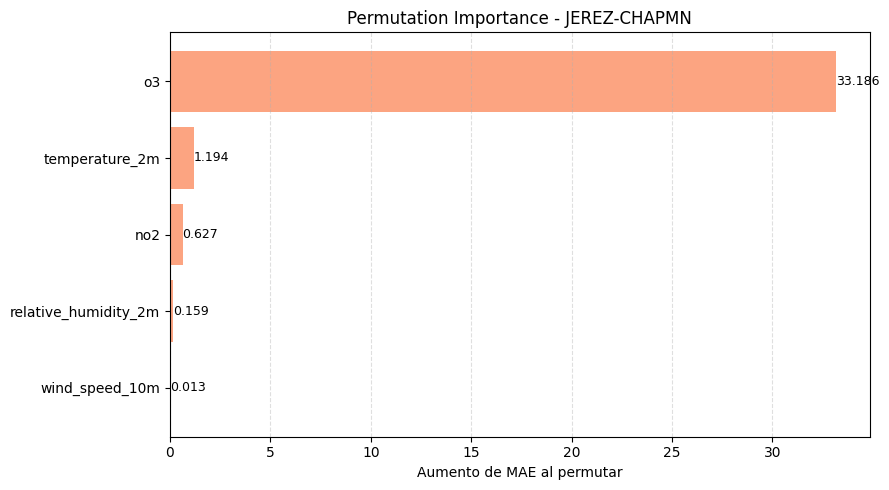

In [ ]:
salida = train_lstm_station_vanilla(
    df_por_estacion["JEREZ-CHAPMN"],
    lookback=72, horizon=1,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#fc8d62",
    nombre_estacion="JEREZ-CHAPMN"
)